## Gonatopoulos-Pournatzis et al (2020) double perturbation screens (CHyMErA screens)

**Genetic interaction mapping and exon-resolution functional genomics with a hybrid Cas9–Cas12a platform**  
https://www.nature.com/articles/s41587-020-0437-z  

Notes:
- Target 1,344 genes that represent paralog pairs
- HAP1 and RPE1 cells
- Effect size represents mean difference in expected and observed LFC at early (T12 for HAP1, T18 for RPE1) or late (T18 for HAP1, T24 for RPE1) time points

**Input**: Supplemental Table 8 - contains several sheets of interest: Summary, HAP1.T12, HAP1.T18, RPE1.T18, RPE1.T24

**Output**: Paralog pairs from screen annotated with negative GI hits and observed LFC

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn2
import re
import os

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../../local_data/' +'/'.join(folders) +'/'+ fname)

file_data = get_data_path(['GI_screens', 'gonatopoulus_2020'], 'Table_S8.xlsx')
file_all_pairs = lambda ens_v: get_local_data_path(['processed', 'ensembl'+ens_v], 'all_pairs.csv')

# Output
file_chymera_pairs_orig = get_local_data_path(['processed','screen_pairs'], 'chymera_pairs_orig.csv')

### Process Table S8 from paper

In [14]:
summary = pd.read_excel(file_data, sheet_name="Summary", skiprows=1)
summary = summary.drop(columns=['torin_gi_type', 'torin_early_effect_size', 'torin_late_effect_size', 'HAP1 +/- Torin'])
print('N pairs:', summary.shape[0])
print('N w/ GI:', summary[summary.hap1_gi_type!='none'].shape[0], summary[summary.rpe1_gi_type!='none'].shape[0])
print('N w/ GI in either:', summary[(summary.hap1_gi_type!='none')|(summary.rpe1_gi_type!='none')].shape[0])
summary[:2]

N pairs: 688
N w/ GI: 219 122
N w/ GI in either: 290


,gene1,gene2,hap1_gi_type,rpe1_gi_type,hap1_early_effect_size,hap1_late_effect_size,rpe1_early_effect_size,rpe1_late_effect_size
0,SEC23A,SEC23B,shared,shared,-3.028953,-3.424526,-2.306238,-2.103825
1,CUL4A,CUL4B,shared,shared,-2.842330,-3.439328,-1.826966,-1.543943


#### Assign original hit calls

In [40]:
# Call negative GI if the effect is seen at either time point (shared), and effect size is negative at both time points
screen_hits = summary.assign(
    hap1_hit = summary.apply(lambda x: ((x.hap1_gi_type!='none') 
                                        and (x.hap1_late_effect_size < 0) and (x.hap1_early_effect_size < 0)), axis=1),
    rpe1_hit = summary.apply(lambda x: ((x.rpe1_gi_type!='none')
                                        and (x.rpe1_late_effect_size < 0) and (x.rpe1_early_effect_size < 0)), axis=1))

print('Num HAP1 SL:', sum(screen_hits.hap1_hit), '/', screen_hits.shape[0])
print('Num RPE1 SL:', sum(screen_hits.rpe1_hit), '/', screen_hits.shape[0])
print('SL in either cell line: %d = %.2f%%' % (sum(screen_hits.hap1_hit | screen_hits.rpe1_hit),
                                               sum(screen_hits.hap1_hit | screen_hits.rpe1_hit)/screen_hits.shape[0]*100))
print('SL in both cell lines: %d = %.2f%%' % (sum(screen_hits.hap1_hit & screen_hits.rpe1_hit),
                                              sum(screen_hits.hap1_hit & screen_hits.rpe1_hit)/screen_hits.shape[0]*100))

# Count num cell lines in which pairs are SL
screen_hits['n_hits'] = screen_hits[['hap1_hit', 'rpe1_hit']].sum(axis=1)
screen_hits = screen_hits[['gene1','gene2','hap1_hit','rpe1_hit','n_hits']].rename(columns={'gene1':'A1','gene2':'A2'})
screen_hits = screen_hits.rename(columns={'gene1':'A1','gene2':'A2'})
screen_hits[:1]

Num HAP1 SL: 214 / 688
Num RPE1 SL: 107 / 688
SL in either cell line: 271 = 39.39%
SL in both cell lines: 50 = 7.27%


,A1,A2,hap1_hit,rpe1_hit,n_hits
0,SEC23A,SEC23B,True,True,2


#### Merge with ensembl

In [41]:
all_pairs_93 = pd.read_csv(file_all_pairs('93'))[['A1','A2']]
print('N=', all_pairs_93.shape[0])
all_pairs_102 = pd.read_csv(file_all_pairs('102'))[['A1','A2']]
print('N=', all_pairs_102.shape[0])

N= 73296
N= 179968


In [42]:
# Merge with our Ensembl list of paralog pairs
screen_pairs = pd.merge(screen_hits, all_pairs_93, how='left', indicator='in_93')
screen_pairs = pd.merge(screen_pairs, all_pairs_102, how='left', indicator='in_102')
screen_pairs['in_93'] = screen_pairs['in_93'] == 'both'
screen_pairs['in_102'] = screen_pairs['in_102'] == 'both'
assert(screen_hits.shape[0] == screen_pairs.shape[0])
print('Overlap w/ Ens.93:', sum(screen_pairs.in_93))
print('Overlap w/ Ens.102:', sum(screen_pairs.in_102))
assert(screen_hits.shape[0] == screen_pairs.shape[0])

# Sorted gene pair column
screen_pairs.insert(0, 'sorted_gene_pair', screen_pairs.apply(lambda x: '_'.join(sorted([x.A1, x.A2])), axis=1))
screen_pairs = screen_pairs.drop(columns=['A1','A2'])
screen_pairs[:2]

Overlap w/ Ens.93: 658
Overlap w/ Ens.102: 642


,sorted_gene_pair,hap1_hit,rpe1_hit,n_hits,in_93,in_102
0,SEC23A_SEC23B,True,True,2,True,True
1,CUL4A_CUL4B,True,True,2,True,True


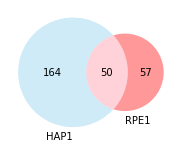

In [43]:
f, ax = plt.subplots(figsize=(3,3))
v = venn2([set(screen_pairs[screen_pairs.hap1_hit]['sorted_gene_pair']), 
           set(screen_pairs[screen_pairs.rpe1_hit]['sorted_gene_pair'])], ['HAP1','RPE1'], ax=ax, set_colors=['skyblue','red'])
for text in v.set_labels: text.set_fontsize(10)

### Merge screen pairs with observed LFC

#### Load observed LFC values

In [44]:
def load_observed_lfc(sheet_name,col_name,new_col_name):
    obs_lfc = pd.read_excel(file_data, sheet_name=sheet_name).drop_duplicates() # there are duplicate rows
    obs_lfc = obs_lfc.rename(columns={col_name:new_col_name}).reset_index(drop=True)
    obs_lfc['sorted_gene_pair'] = obs_lfc.apply(lambda x: '_'.join(sorted([x.gene1, x.gene2])), axis=1)
    obs_lfc = obs_lfc[['sorted_gene_pair', new_col_name]]
    return obs_lfc

In [45]:
hap1_t1 = load_observed_lfc('HAP1.T12','early_mean_observed_LFC','hap1_early_obs_LFC')
hap1_t1[:1]

,sorted_gene_pair,hap1_early_obs_LFC
0,ABHD12_ABHD12B,-0.067548


In [46]:
hap1_t2 = load_observed_lfc('HAP1.T18','late_mean_observed_LFC','hap1_late_obs_LFC')
hap1_t2[:1]

,sorted_gene_pair,hap1_late_obs_LFC
0,ABHD12_ABHD12B,-0.130963


In [47]:
rpe1_t1 = load_observed_lfc('RPE1.T18','early_mean_observed_LFC','rpe1_early_obs_LFC')
rpe1_t1[:1]

,sorted_gene_pair,rpe1_early_obs_LFC
0,ABHD12_ABHD12B,-0.288012


In [48]:
rpe1_t2 = load_observed_lfc('RPE1.T24','late_mean_observed_LFC','rpe1_late_obs_LFC')
rpe1_t2[:1]

,sorted_gene_pair,rpe1_late_obs_LFC
0,ABHD12_ABHD12B,-0.300921


#### Merge observed LFC values with screen hits

In [51]:
screen_pairs_w_lfc = pd.merge(screen_pairs, hap1_t1)
screen_pairs_w_lfc = pd.merge(screen_pairs_w_lfc, hap1_t2)
screen_pairs_w_lfc = pd.merge(screen_pairs_w_lfc, rpe1_t1)
screen_pairs_w_lfc = pd.merge(screen_pairs_w_lfc, rpe1_t2)
display(screen_pairs_w_lfc[:1])

screen_pairs_w_lfc = screen_pairs_w_lfc.assign(
    min_hap1_lfc = screen_pairs_w_lfc.apply(lambda x: min(x.hap1_early_obs_LFC, x.hap1_late_obs_LFC), axis=1),
    min_rpe1_lfc = screen_pairs_w_lfc.apply(lambda x: min(x.rpe1_early_obs_LFC, x.rpe1_late_obs_LFC), axis=1))

screen_pairs_w_lfc = screen_pairs_w_lfc[['sorted_gene_pair','hap1_hit','rpe1_hit','n_hits','min_hap1_lfc','min_rpe1_lfc',
                                         'in_93','in_102']]
# Num hits should be the same as seen earlier
assert((sum(screen_pairs_w_lfc.hap1_hit)==sum(screen_pairs.hap1_hit)) & 
       (sum(screen_pairs_w_lfc.rpe1_hit)==sum(screen_pairs.rpe1_hit)))
screen_pairs_w_lfc[:1]

,sorted_gene_pair,hap1_hit,rpe1_hit,n_hits,in_93,in_102,hap1_early_obs_LFC,hap1_late_obs_LFC,rpe1_early_obs_LFC,rpe1_late_obs_LFC
0,SEC23A_SEC23B,True,True,2,True,True,-1.896861,-2.079895,-1.644239,-1.96918


,sorted_gene_pair,hap1_hit,rpe1_hit,n_hits,min_hap1_lfc,min_rpe1_lfc,in_93,in_102
0,SEC23A_SEC23B,True,True,2,-2.079895,-1.96918,True,True


In [52]:
screen_pairs_w_lfc.to_csv(file_chymera_pairs_orig)